<a href="https://colab.research.google.com/github/Sathwik-i9/Basicml/blob/main/Credit_Card.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'fraud-detection:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F817870%2F1399887%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240219%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240219T080609Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D95d22e66a2a50556431202d04183085a791ee51b859fcfa9cbdccee5cf5a50197f7ea1a2171a5d0fd55610c7055c6e8224d1db896114f157ec873860b7382162288193bfb7f42feffff2c0049822f412e5802cf07ac69cec7ce1af20592752c902574b0eafe771b5dc3fe4184c7d0717cd07410a6b1fe1af88b57e7ce387a3db70d5cb875b1ac9c111bab5b10e3e256ef461eafe2f81efad8f23329b0c1dcb933623223ade1ace56514cfbd17459d37b2de70b5afde6a88d01e805a5ba2bfc6626f90b77b15d510d96e75a731114a327ff49cd5702bd2512202327cb8247c0f48b51beb4bd6020f369ac5168d920c8f9fc8cd4b22dc12348da52804b7232dc64'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 211766662 bytes downloaded
Downloaded and uncompressed: fraud-detection
Data source import complete.


# **Importing Libraries**

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set_style('whitegrid')
sns.set_palette('Set2')

import warnings
warnings.filterwarnings("ignore")

# **Loading Data**

In [3]:
train = pd.read_csv('/kaggle/input/fraud-detection/fraudTrain.csv',index_col='Unnamed: 0')
test = pd.read_csv('/kaggle/input/fraud-detection/fraudTest.csv',index_col='Unnamed: 0')

In [4]:
train.head(2)

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0


In [5]:
train.shape

(1296675, 22)

In [6]:
train.columns

Index(['trans_date_trans_time', 'cc_num', 'merchant', 'category', 'amt',
       'first', 'last', 'gender', 'street', 'city', 'state', 'zip', 'lat',
       'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time', 'merch_lat',
       'merch_long', 'is_fraud'],
      dtype='object')

In [7]:
columns_drop = ["unix_time","merchant","first","street"]
train.drop(columns = columns_drop,inplace= True)
test.drop(columns = columns_drop,inplace= True)

**Droping Certain unuseful columns**


# **EDA**

In [8]:
train.isna().sum().sum(),train.duplicated().sum()

(0, 0)

**No null or duplicate values**

In [9]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
cc_num,1296675.0,4.171920e+17,1.308806e+18,6.041621e+10,1.800429e+14,3.521417e+15,4.642255e+15,4.992346e+18
amt,1296675.0,7.035104e+01,1.603160e+02,1.000000e+00,9.650000e+00,4.752000e+01,8.314000e+01,2.894890e+04
zip,1296675.0,4.880067e+04,2.689322e+04,1.257000e+03,2.623700e+04,4.817400e+04,7.204200e+04,9.978300e+04
lat,1296675.0,3.853762e+01,5.075808e+00,2.002710e+01,3.462050e+01,3.935430e+01,4.194040e+01,6.669330e+01
long,1296675.0,-9.022634e+01,1.375908e+01,-1.656723e+02,-9.679800e+01,-8.747690e+01,-8.015800e+01,-6.795030e+01
city_pop,1296675.0,8.882444e+04,3.019564e+05,2.300000e+01,7.430000e+02,2.456000e+03,2.032800e+04,2.906700e+06
merch_lat,1296675.0,3.853734e+01,5.109788e+00,1.902779e+01,3.473357e+01,3.936568e+01,4.195716e+01,6.751027e+01
merch_long,1296675.0,-9.022646e+01,1.377109e+01,-1.666712e+02,-9.689728e+01,-8.743839e+01,-8.023680e+01,-6.695090e+01
is_fraud,1296675.0,5.788652e-03,7.586269e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00


In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1296675 entries, 0 to 1296674
Data columns (total 18 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   trans_date_trans_time  1296675 non-null  object 
 1   cc_num                 1296675 non-null  int64  
 2   category               1296675 non-null  object 
 3   amt                    1296675 non-null  float64
 4   last                   1296675 non-null  object 
 5   gender                 1296675 non-null  object 
 6   city                   1296675 non-null  object 
 7   state                  1296675 non-null  object 
 8   zip                    1296675 non-null  int64  
 9   lat                    1296675 non-null  float64
 10  long                   1296675 non-null  float64
 11  city_pop               1296675 non-null  int64  
 12  job                    1296675 non-null  object 
 13  dob                    1296675 non-null  object 
 14  trans_num         

**There are a lot of categorical features! So we need to encode them**

**Highly imbalanced classes** Because of this, Oversampling/Undersampling can be used in the model.

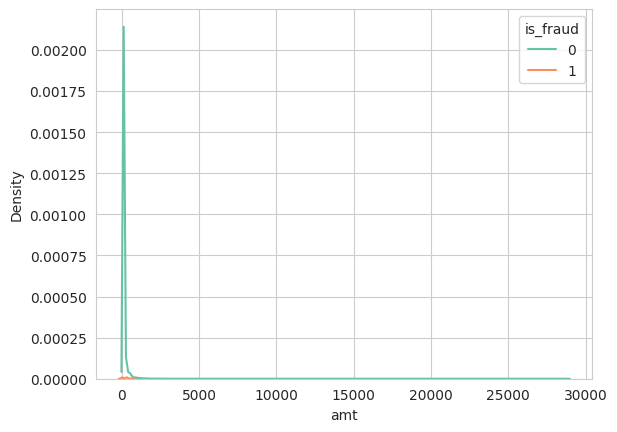

In [12]:
sns.kdeplot(x="amt", hue="is_fraud",data=train);

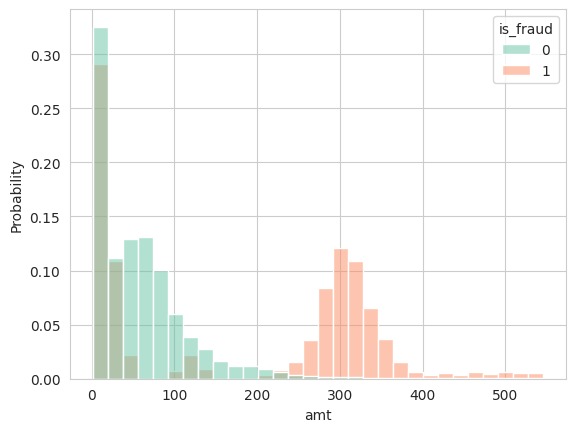

In [13]:
pct99 = train["amt"].quantile(0.99)
sns.histplot(x="amt", hue="is_fraud", bins=30,
             stat="probability", data=train[train["amt"] <= pct99],
             common_norm=False);

**the probability distribution behaves differently for each value of "is_fraud".**

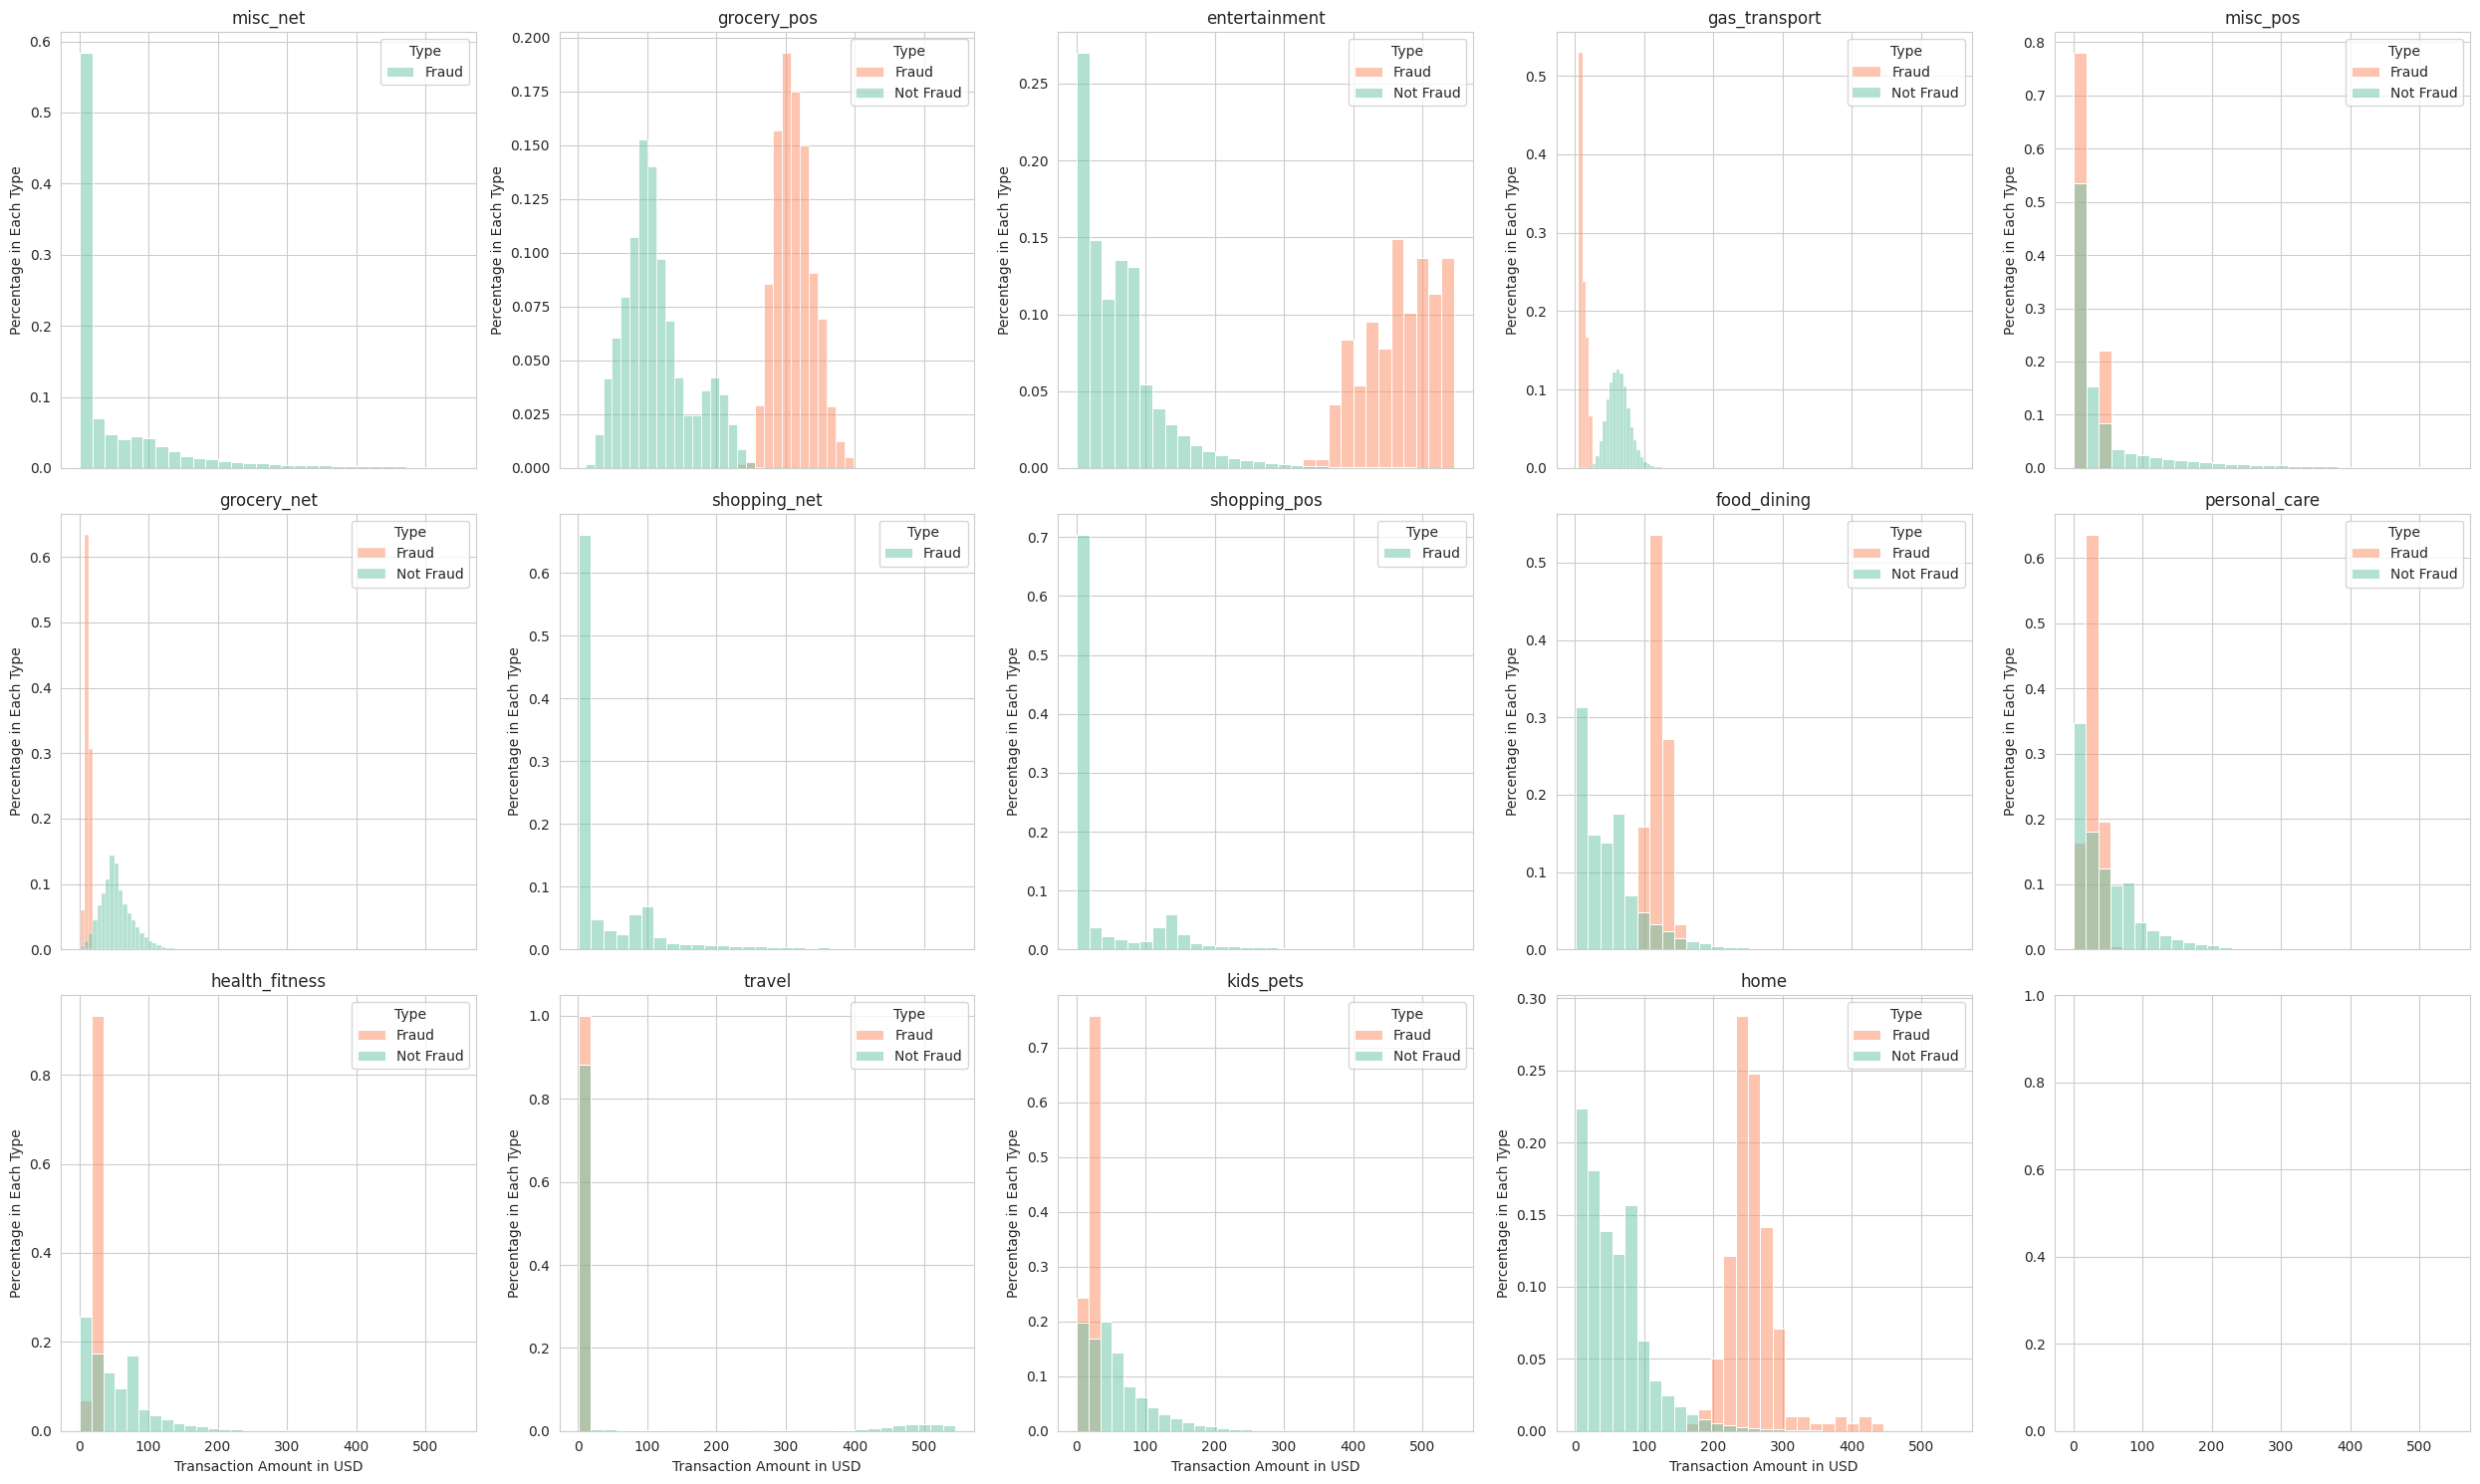

In [14]:
import math
categories = train['category'].unique()

num_plots = len(categories)
num_rows = math.isqrt(num_plots)
num_cols = math.ceil(num_plots / num_rows)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(
    5*num_cols, 5*num_rows), sharex=True)

for ax, category in zip(axes.ravel(),categories):

    data_category = train[train['category'] == category]

    sns.histplot(x='amt', data=data_category[data_category['amt'] <= pct99],
                 hue='is_fraud', stat='probability',
                 common_norm=False, bins=30, ax=ax)

    ax.set_ylabel('Percentage in Each Type')
    ax.set_xlabel('Transaction Amount in USD')
    ax.set_title(f'{category}')
    ax.legend(title='Type', labels=['Fraud', 'Not Fraud'])

plt.tight_layout()
plt.show();

**There are patterns in categories hence we must consider categories for modelling**

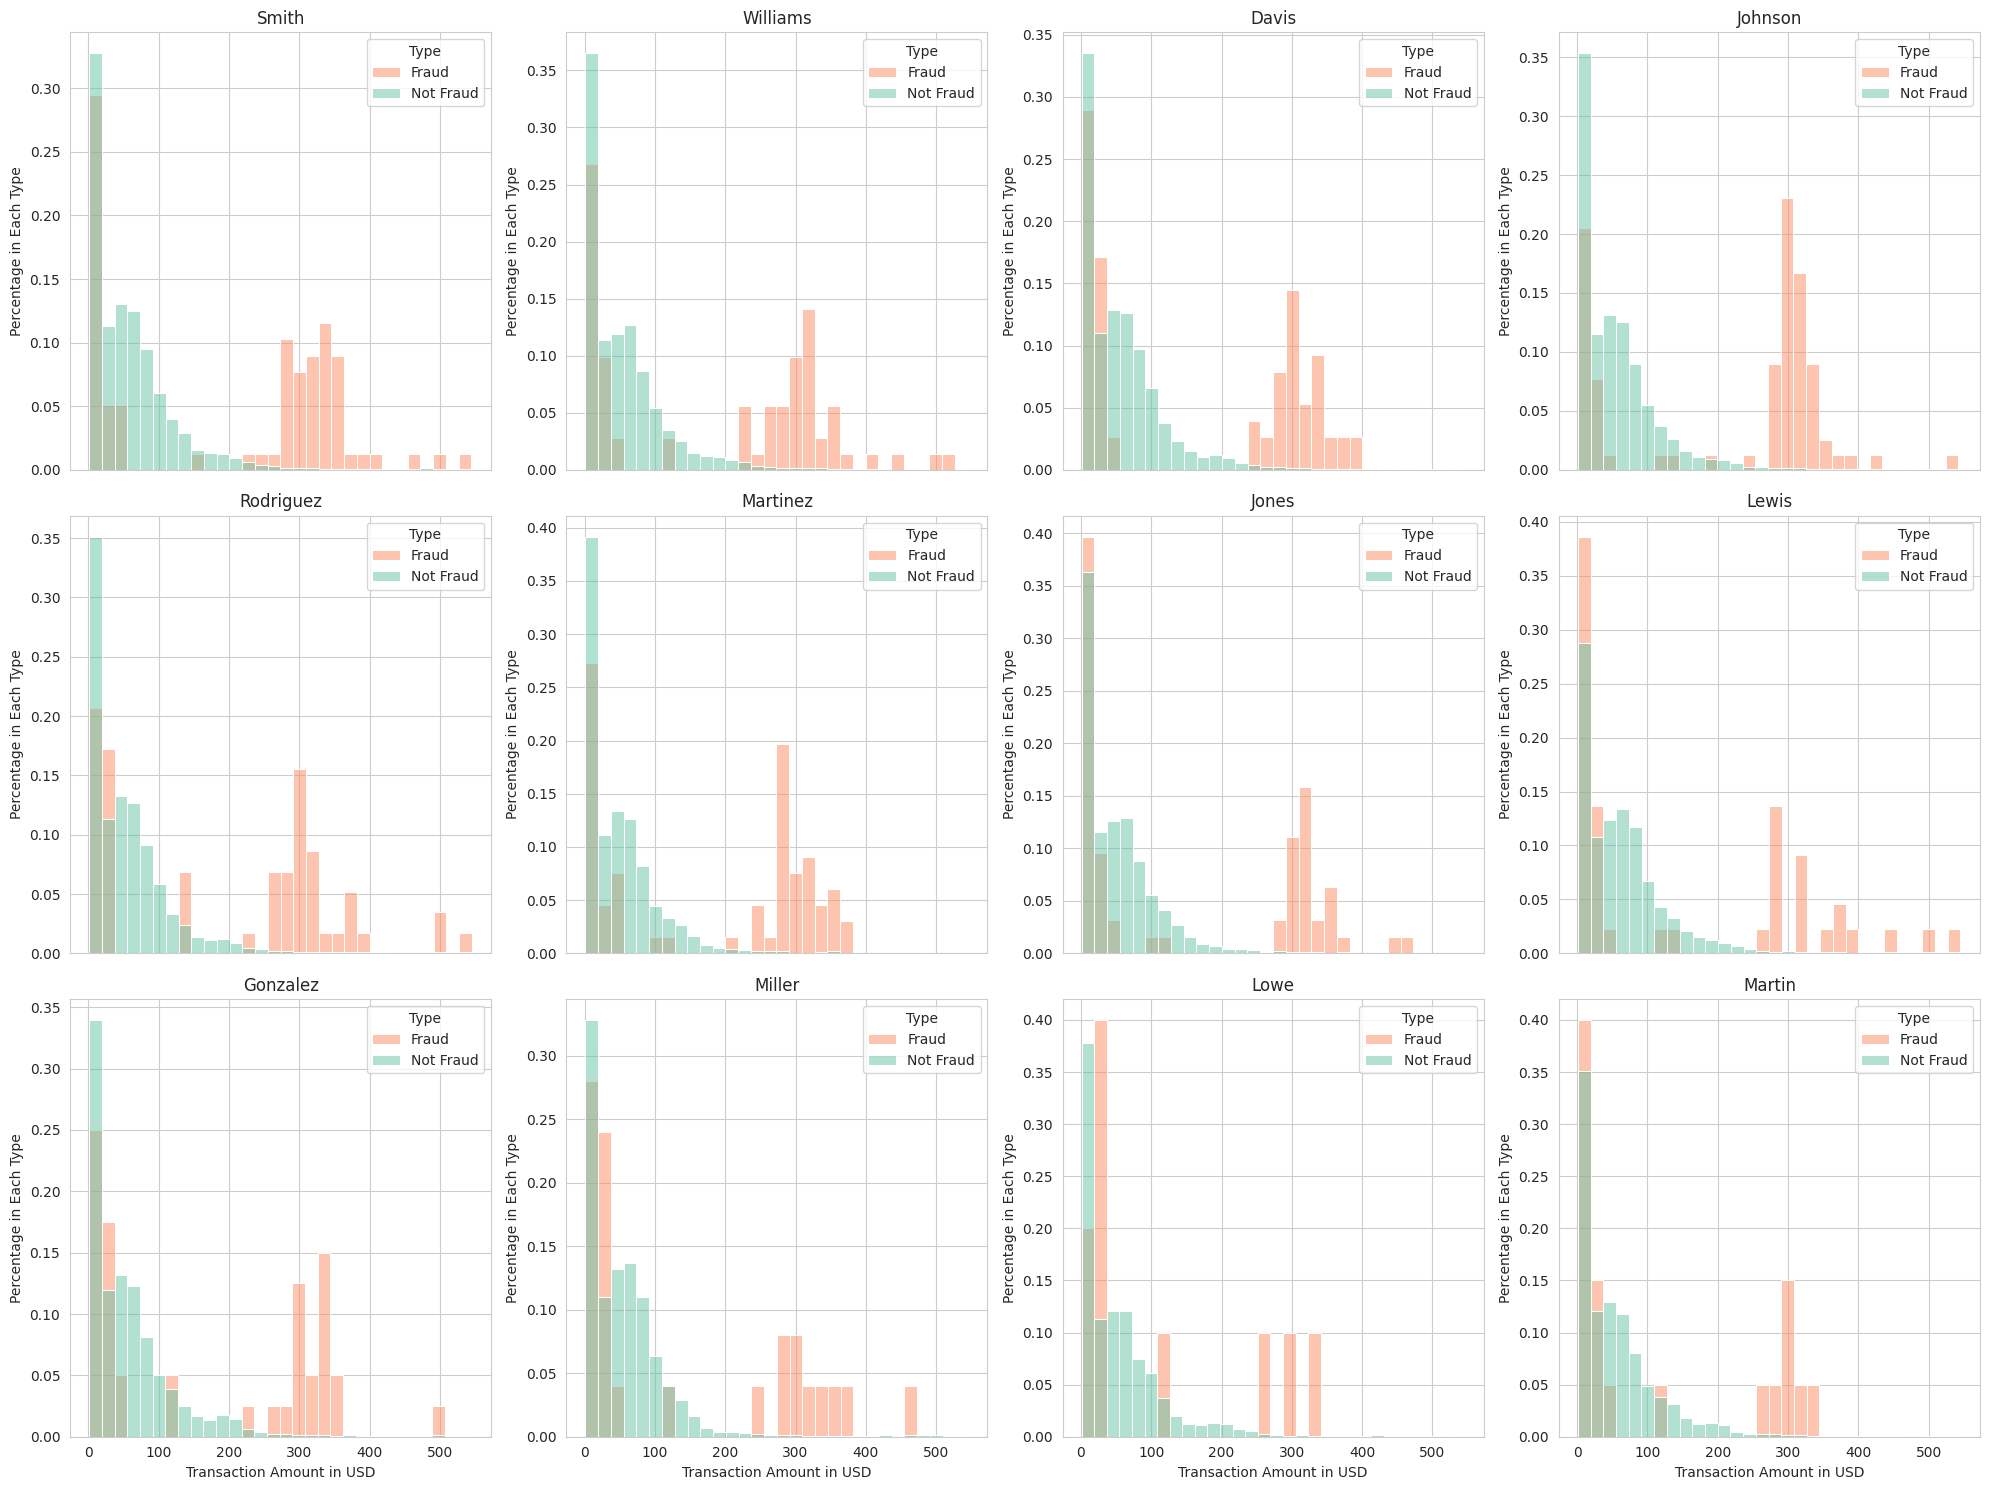

In [15]:
import math
lastnames = train['last'].value_counts().index[:12]

num_plots = len(lastnames)
num_rows = math.isqrt(num_plots)
num_cols = math.ceil(num_plots / num_rows)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(
    5*num_cols, 5*num_rows), sharex=True)



for ax, lastname in zip(axes.ravel(),lastnames):

    data_lastname = train[train['last'] == lastname]

    sns.histplot(x='amt', data=data_lastname[data_lastname['amt'] <= pct99],
                 hue='is_fraud', stat='probability',
                 common_norm=False, bins=30, ax=ax)

    ax.set_ylabel('Percentage in Each Type')
    ax.set_xlabel('Transaction Amount in USD')
    ax.set_title(f'{lastname}')
    ax.legend(title='Type', labels=['Fraud', 'Not Fraud'])

plt.tight_layout()
plt.show();

**There are patterns in lastnames as well hence we must consider Lastnames for modelling**

In [16]:
train["state"].value_counts().shape

(51,)

In [17]:
train.groupby("state")["is_fraud"].value_counts()

state  is_fraud
AK     0            2084
       1              36
AL     0           40774
       1             215
AR     0           30966
                   ...  
WI     1             163
WV     0           25545
       1             146
WY     0           19212
       1             110
Name: is_fraud, Length: 101, dtype: int64

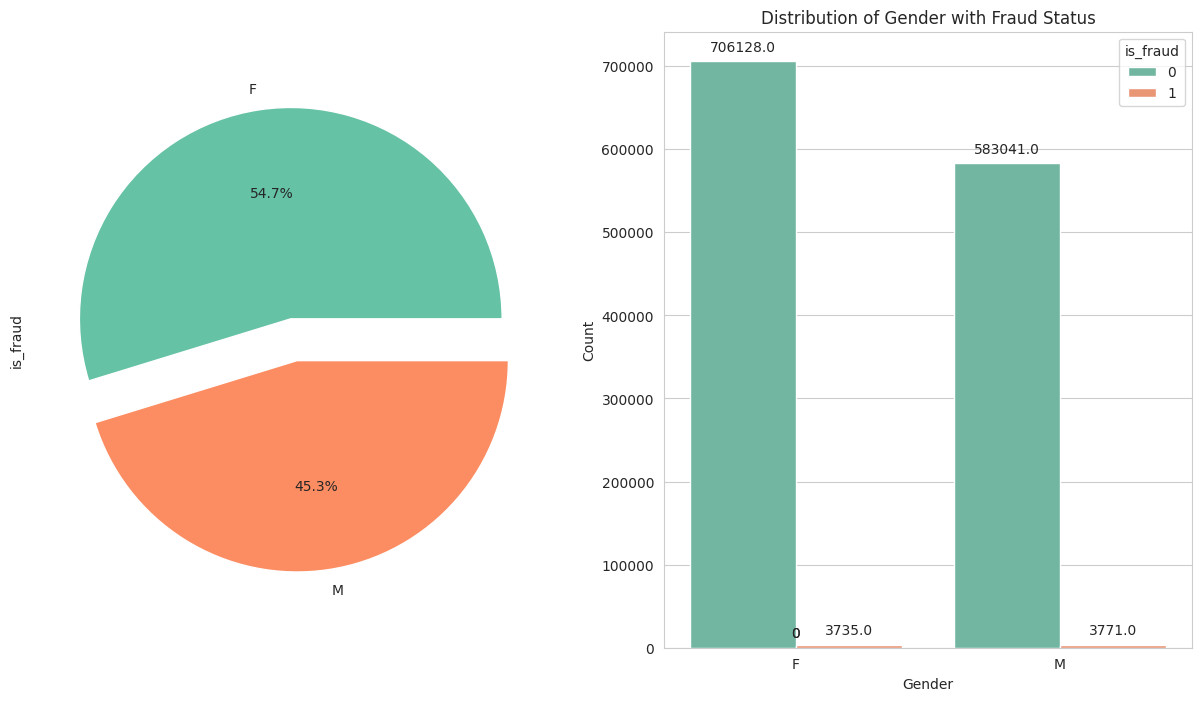

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

fig,axb = plt.subplots(ncols=2,nrows=1,figsize=(15, 8))

#Gender Distribution
explode = [0.1, 0.1]
train.groupby('gender')['is_fraud'].count().plot.pie(explode=explode, autopct="%1.1f%%",ax=axb[0]);

ax = sns.countplot(x="gender", hue="is_fraud", data=train,ax=axb[1])

# Add values on top of each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Set labels and title
plt.title("Distribution of Gender with Fraud Status")
plt.xlabel("Gender")
plt.ylabel("Count")

# Show the plot
plt.show()

**Females are doing more transactions but males are more likely to make fraud transaction**

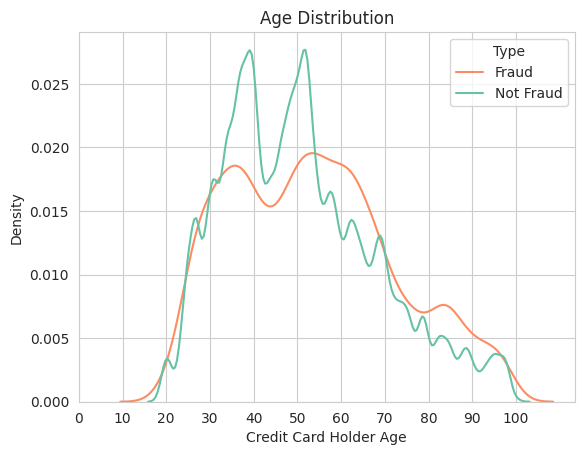

In [19]:
import datetime as dt

train['age'] = dt.date.today().year-pd.to_datetime(train['dob']).dt.year
test['age'] = dt.date.today().year-pd.to_datetime(test['dob']).dt.year

ax = sns.kdeplot(x='age', data=train, hue='is_fraud', common_norm=False)
ax.set_xlabel('Credit Card Holder Age')
ax.set_ylabel('Density')
plt.xticks(np.arange(0, 110, 10))
plt.title('Age Distribution')
plt.legend(title='Type', labels=['Fraud', 'Not Fraud']);

**age has a less major impact on target**

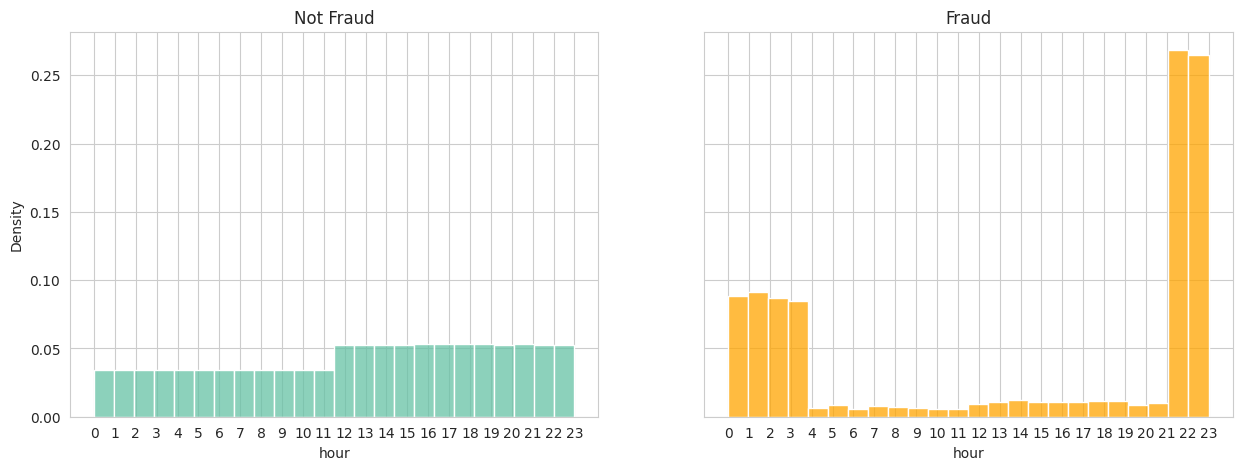

In [20]:
train['hour'] = pd.to_datetime(train['trans_date_trans_time']).dt.hour
test['hour'] = pd.to_datetime(test['trans_date_trans_time']).dt.hour

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5), sharey=True)

ax1 = sns.histplot(x='hour', data=train[train["is_fraud"] == 0],
                   stat="density", bins=24, ax=ax1)

ax2 = sns.histplot(x='hour', data=train[train["is_fraud"] == 1],
                   stat="density", bins=24, ax=ax2, color="orange")

ax1.set_title("Not Fraud")
ax2.set_title("Fraud")

ax1.set_xticks(np.arange(24))
ax2.set_xticks(np.arange(24));

**It is clear that fraud transactions mainly occur at midnight.**

# **Preparing Data For Modelling**

In [21]:
train.dtypes

trans_date_trans_time     object
cc_num                     int64
category                  object
amt                      float64
last                      object
gender                    object
city                      object
state                     object
zip                        int64
lat                      float64
long                     float64
city_pop                   int64
job                       object
dob                       object
trans_num                 object
merch_lat                float64
merch_long               float64
is_fraud                   int64
age                        int64
hour                       int64
dtype: object

In [22]:
train["gender"]= train["gender"].apply(lambda x: 1 if x == "M" else 0)
test["gender"]= test["gender"].apply(lambda x: 1 if x == "M" else 0)

In [24]:
!pip install category_encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 1.2 MB/s eta 0:00:00


In [25]:
import category_encoders as ce

def apply_woe(train, columns, target_col):
    woe = ce.WOEEncoder()

    for col in columns:
        X = train[col]
        y = train[target_col]

        new_col_name = f"{col}_WOE"
        train[new_col_name] = woe.fit_transform(X, y)

    return train


columns_to_encode = ["category", "state", "city", "job","last"]
target_column = "is_fraud"

train = apply_woe(train, columns_to_encode, target_column)
test = apply_woe(test, columns_to_encode, target_column)

In [26]:
col_drop = ["is_fraud","trans_date_trans_time","trans_num","dob","category", "state", "city", "job","last"]
X_train,X_test,y_train,y_test = train.drop(columns=col_drop),test.drop(columns=col_drop),train["is_fraud"],test["is_fraud"]

In [27]:
X_train.dtypes

cc_num            int64
amt             float64
gender            int64
zip               int64
lat             float64
long            float64
city_pop          int64
merch_lat       float64
merch_long      float64
age               int64
hour              int64
category_WOE    float64
state_WOE       float64
city_WOE        float64
job_WOE         float64
last_WOE        float64
dtype: object

In [28]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(sampling_strategy=0.1, random_state=23)
# X_undersampled, y_undersampled = rus.fit_resample(X_train, y_train)
X_undersampled, y_undersampled = X_train, y_train

**Tried Undersampling but without Undersampling model has greater score so commented it**

In [29]:
# y_train.value_counts(),y_undersampled.value_counts()

**undersampled normal transactions from 12L to 75k**

In [30]:
X_undersampled.sample(2)

,cc_num,amt,gender,zip,lat,long,city_pop,merch_lat,merch_long,age,hour,category_WOE,state_WOE,city_WOE,job_WOE,last_WOE
242983,4658490815480264,7.04,0,15449,39.9636,-79.7853,184,40.833481,-79.689136,79,22,-0.698428,-0.007292,-2.486131,-1.162573,0.034507
712383,2720433095629877,90.84,1,4287,44.0575,-69.9656,3224,44.471991,-70.424670,27,13,0.898799,0.229034,-0.057575,0.137932,0.072985


<Axes: >

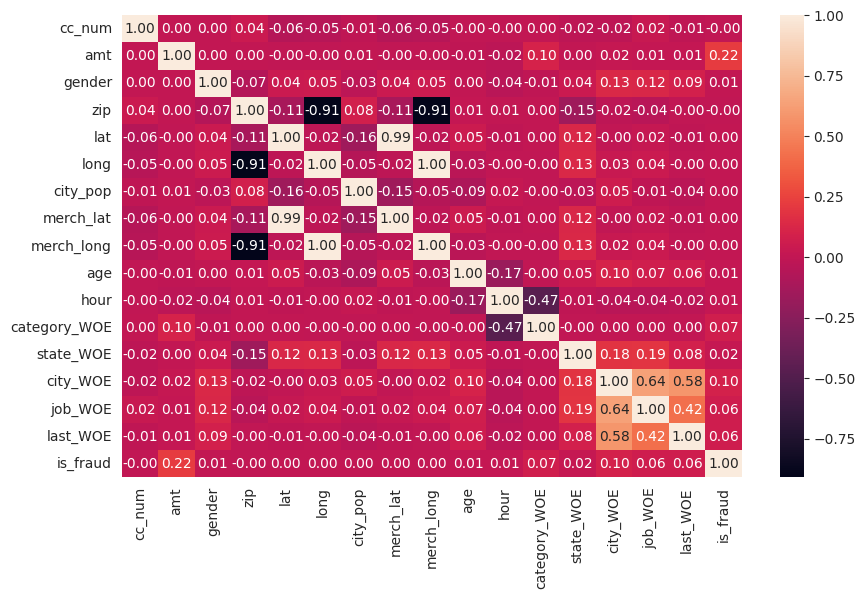

In [31]:
plt.figure(figsize=(10,6))
sns.heatmap(pd.concat([X_undersampled,y_undersampled],axis=1).corr(),annot=True,fmt='.2f')

**Amount has the highest corelation with fraud other columns have very negligible effect on fraud transaction**

In [32]:
# col_d = ["zip","lat","long","city_pop","merch_lat", "merch_long", "cc_num"]
col_d = []

X_train = X_undersampled.drop(columns=col_d)
X_test =  X_test.drop(columns=col_d)
y_train = y_undersampled

**Tried Dropping these columns but score is greater keeping these columns**

In [33]:
X_train.head(2)

,cc_num,amt,gender,zip,lat,long,city_pop,merch_lat,merch_long,age,hour,category_WOE,state_WOE,city_WOE,job_WOE,last_WOE
0,2703186189652095,4.97,0,28654,36.0788,-81.1781,3495,36.011293,-82.048315,36,0,0.924914,-0.156457,-2.469513,-1.080186,-2.469513
1,630423337322,107.23,0,99160,48.8878,-118.2105,149,49.159047,-118.186462,46,0,0.898799,-0.122657,-3.027790,-0.904144,-0.673638


In [34]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [35]:
X_train.shape,y_train.shape,X_test.shape,y_test.shape

((1296675, 16), (1296675,), (555719, 16), (555719,))

In [36]:
#classification report
from sklearn.metrics import classification_report,confusion_matrix,precision_score,accuracy_score

In [37]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(X_train,y_train)

RandomForestClassifier()

In [38]:
rf.score(X_test,y_test)

0.998938312348507

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.95      0.76      0.85      2145

    accuracy                           1.00    555719
   macro avg       0.98      0.88      0.92    555719
weighted avg       1.00      1.00      1.00    555719



<Axes: >

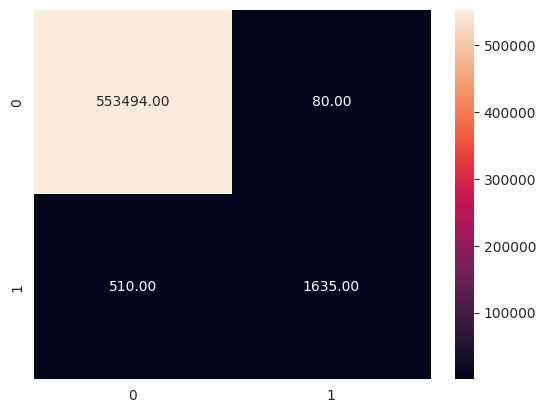

In [39]:
y_pred = rf.predict(X_test)
print(classification_report(y_test,y_pred))
cnf = confusion_matrix(y_test,y_pred)
sns.heatmap(cnf,annot=True,fmt=".2f")

**Feature Importance**

In [40]:
print("Accuracy: ", accuracy_score(y_test,y_pred))
print("Precision: ", precision_score(y_test,y_pred))

Accuracy:  0.998938312348507
Precision:  0.9533527696793003


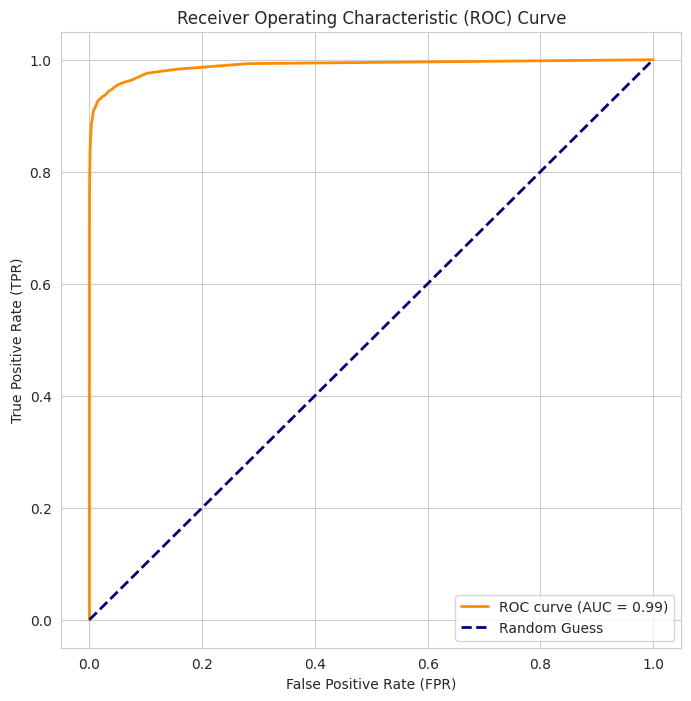

In [41]:
from sklearn.metrics import roc_curve, roc_auc_score, auc
y_prob = rf.predict_proba(X_test)[:, 1]

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Calculate the AUC (Area Under the Curve) score
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

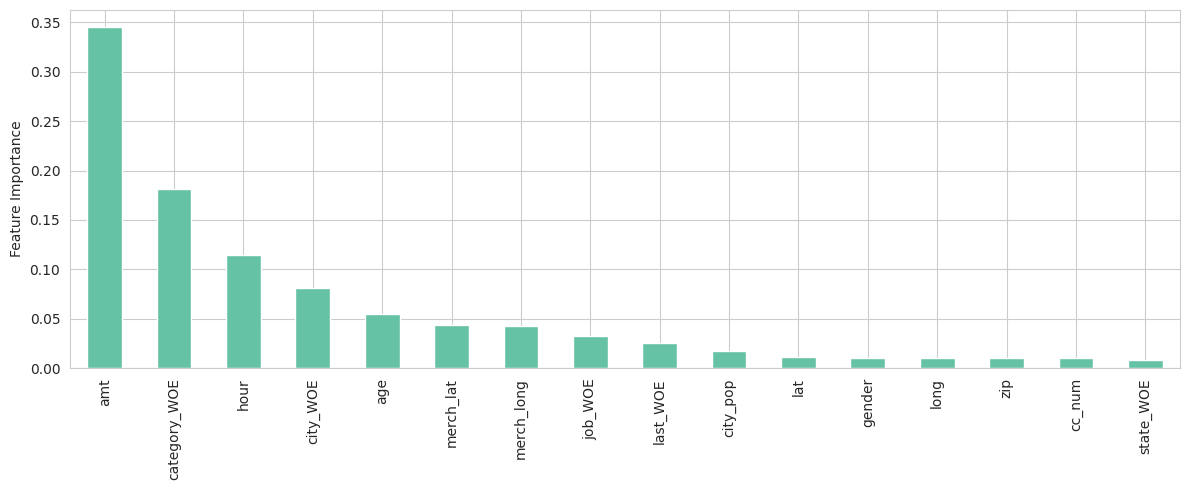

In [42]:
importances = rf.feature_importances_
forest_importances = pd.Series(importances,index=X_undersampled.columns)
fig, ax = plt.subplots(figsize=(12, 5))
forest_importances.sort_values(ascending=False).plot.bar(ax=ax)
ax.set_ylabel("Feature Importance")
fig.tight_layout();